# Lab 2. PyTorch models

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`


**Homework Tasks**

 - Homework tasks are clearly marked throughout the notebook in the following format:

   > ---

   > <span style="color:red"><b>TASK X</b> - [<i>some text</i>]:</span>

   > ---

   > ```Your code ....```

   > ---

   > *End of Task X.* [*Instructions for passing*]

 - For each task:
   - **Complete the code** where indicated.
   - **Upload the required results** from each task to **Homework 2 – Code** on [NextIlearn](https://nextilearn.dsv.su.se).

 - Once you've finished all the tasks:
   Submit your **entire completed notebook (including your code!)** to **Homework 2 – Notebook** on [NextIlearn](https://nextilearn.dsv.su.se).

**Important:**  
Your submission will **only be graded if both files** (code + notebook) are uploaded **before the deadline**. Late submissions are **not accepted**, regardless of technical issues like bad internet connection.

---

This lab will teach how to use PyTorch by making a simple neural network model. Regradless of model's complexity, creating any model can be completed in a similar way. We will use the **Fashion MNIST** dataset, one of the variants of the MNIST dataset. It has the same property as a normal MNIST, with the same size (28*28) and the same number of classes (10), but the images represent fashion items rather than handwritten digits, which means it might have more complexity than normal MNIST.

Because of its complexity in each class, the problem is significantly more challenging than normal MNIST. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST. Below is an example of Fashion MNIST.


![alt text](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)


In today's lab, we will first try to create a simple fully connected network model and check its basic performance on Fashion MNIST.

Based on your local machine's performance, the task might take a long time, so it is recommended to use the [Google Colab](https://colab.research.google.com/) since it can handle the lab contents with no processing bottleneck.

### Contents

- Import PyTorch and load a sample dataset
- Sequential fully connected network
- Other useful functions (Saving/Loading)

### Section 1: Import PyTorch and load a sample dataset


You should be able to install PyTorch by using `pip`. You do not need to specify a GPU version.

In [1]:
%%capture
!pip install numpy torch

In [2]:
import torch as pt

In [3]:
import numpy as np

In [4]:
# version?
pt.__version__

'2.6.0+cu124'

We will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) data available in github, which has 70,000 article images. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Since it is on github we can simple get it by using `git clone [repo] [folder]`:

In [5]:
!git clone https://github.com/zalandoresearch/fashion-mnist data

Cloning into 'data'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 2 (delta 0), pack-reused 758 (from 1)
Receiving objects: 100% (762/762), 105.85 MiB | 45.43 MiB/s, done.
Resolving deltas: 100% (444/444), done.


#### Dataset handling: Traditional way with scikit-learn

Datasets can be found in diverse locations -- e.g. on [github](https://github.com/), [zenodo](https://zenodo.org/), [huggingface](https://huggingface.co/docs/hub/en/datasets), [kaggle](https://www.kaggle.com/datasets) or **your companies server**. Some Python modules like `torch` and `tensorflow` also have their own easy-to-use versions of standard datasets specialised to the specific library. For a fast, but less general alternative to this tutorial, see [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). **The linked tutorial is for interrested students and not part of this assignment!**

If the dataset is hosted on github or similar, the first step is to check the description: [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist#get-the-data)

Lets check out the `mnist_reader` they mention:

In [6]:
!cat data/utils/mnist_reader.py # linux / mac
#!type data\utils\mnist_reader.py # windows

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


What values does the parameter `kind` take?

In [7]:
import os
os.listdir('data/data/fashion')

['train-images-idx3-ubyte.gz',
 't10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-labels-idx1-ubyte.gz']

Let's load the data:

In [8]:
# import mnist_reader:
import data.utils.mnist_reader as mnist_reader

In [9]:
# load data:
X_train_full, y_train_full = mnist_reader.load_mnist('data/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

This dataset is loaded as a NumPy array which we learned before in Lab 1. You can use all the methods you learned to check the properties of the dataset, like **shape** or **describe**.

In [10]:
# type?
type(X_train_full)

numpy.ndarray

In [11]:
# shape?
X_train_full.shape, X_test.shape

((60000, 784), (10000, 784))

In [12]:
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

As the dataset is composed of grayscale pixels, the datatype of it is unsigned integer. The dataset also has a pixed range [0, 255] so it does not need to take higher bit than 8.

In [13]:
# dtype?
X_train_full.dtype

dtype('uint8')

Besides that, PyTorch models are also usually evaluated by one more separate set called validation set as training is an iterative and time-consuming process and we do not know when we need to stop clearly. So we would like to estimate the right time to interrupt the training process by checking its performance for each iteration.

To create a validation set, there can be many options, we can explicitly split the dataset using index, or we can just use a training set but with the option stating we want to validate, when we actually fit the model. However, this time we will use scikit-learn's `train_test_split` method to create a validation set as it can provide a nice stratification option.

We need a simiple normalization - as we all know the graysclae ranges from 0 to 255...

In [14]:
# Introduced in the coursebook
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [15]:
X_test = X_test / 255.

---

<span style="color:red"><b>TASK 1</b> - Stratified Split:</span>

---

Replace the above simple training/validation split with a **stratified** one (50% train, 50% validation):
  - Use `X_train_full` and `y_train_full`
  - Enable `shuffle` and `stratification`

Use [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Print and check their shapes afterward!

In [16]:
from sklearn.model_selection import train_test_split

# normalize:
X_train_full = X_train_full / 255.

# split data:
X_train, X_valid, y_train, y_valid =train_test_split(X_train_full,y_train_full,train_size=0.5,shuffle=True,stratify = y_train_full) #continue

In [17]:
# shape?
#continue
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(30000, 784)
(30000, 784)
(30000,)
(30000,)


---

*End of Task 1. Copy your final code to **Homework 2 - Code** on **NextIlearn***

Here we prepared the class names of the fashion MNIST dataset for your convenience.

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [19]:
# Use the numeric label to get the class name, e.g:
class_names[0]

'T-shirt/top'

We can also try to see each data instance by using **plt.imshow**.

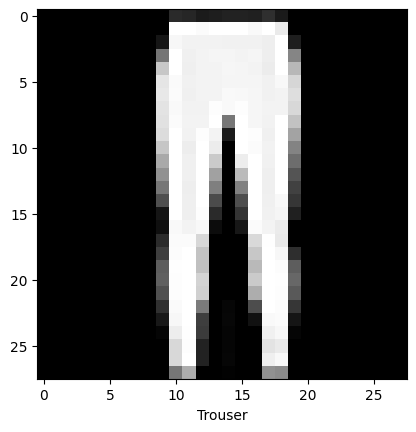

In [20]:
import matplotlib.pyplot as plt
i = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[i].reshape((28, 28)), cmap='gray') # cmap to make it recognize grayscale
plt.xlabel(class_names[y_train[i]])
plt.show()

#### Optimizing memory consuption using pipelines:

Imagine taking the above approach with very large datasets (e.g. used for training modern LLMs). Loading all the data before training would exceed RAM and VRAM of almost any computer.

Therefore, we are going to use the [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) API:

---
***An abstract class representing a Dataset.***

*All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite* `__getitem__()`*, supporting fetching a data sample for a given key. Subclasses could also optionally overwrite* `__len__()`*, which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader. Subclasses could also optionally implement* `__getitems__()`*, for speedup batched samples loading. This method accepts list of indices of samples of batch and returns list of samples.*

---

In [21]:
from numpy.typing import NDArray
from typing import Tuple
from torch.utils.data import Dataset

class FashionMNIST(Dataset):
  def __init__(self, X:NDArray[np.int8], y:NDArray[np.int8]) -> None:
    # normalize:
    self.X = X.astype(np.float32) / 255.0
    self.y = y

  def __len__(self) -> int:
    return len(self.y)

  def __getitem__(self, idx:int) -> int:
    return self.X[idx], self.y[idx]

  @staticmethod
  def create_split(fraction_train:float, fraction_validation:float, fraction_test:float) -> Tuple[Dataset, Dataset, Dataset]:
    assert fraction_train + fraction_validation + fraction_test == 1.0

    # load data:
    train = mnist_reader.load_mnist('data/data/fashion', kind='train')
    t10k  = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

    data   = np.concatenate((train[0], t10k[0]), axis=0)
    labels = np.concatenate((train[1], t10k[1]), axis=0)

    # split data:
    n = len(labels)
    n_train = int(n * fraction_train)
    n_validation = int(n * fraction_validation)

    data_train = FashionMNIST(
        data[:n_train],
        labels[:n_train]
    )
    data_valid = FashionMNIST(
        data[n_train:n_train+n_validation],
        labels[n_train:n_train+n_validation]
    )
    data_test = FashionMNIST(
        data[n_train+n_validation:],
        labels[n_train+n_validation:]
    )

    return data_train, data_valid, data_test

It works like a list of tuples `(X, y)` in Python:

In [22]:
data, _, _ = FashionMNIST.create_split(.7, .1, .2)

In [23]:
# call to __len__:
len(data)

49000

In [24]:
# call to __getitem__:
data[5]

(array([0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.        , 0.        , 0.        , 0.08627451,
        0.34509805, 0.7372549 , 0.6745098 , 0.5176471 , 0.49019608,
        0.5529412 , 0.78039217, 0.56078434, 0.03529412, 0.        ,
        0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00392157, 0.        , 0.        , 0.07843138,
        0.5137255 , 0.78039217, 0.80784315, 0.76862746, 0.7921569 ,
        0.9490196 , 1.        , 1.        , 0.98039216, 0.87058824,
        0.77254903, 0.80784315, 0.7372549 , 0.49411765, 0.06666667,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.13725491, 0.8392157 , 0.7490196 , 0.7176471 ,
        0.69803923, 0.6862745 , 0.65882355, 0.5882353 , 0.63529414,
        0.62352943, 0.59607846, 0.61960787, 0.70

But the above implementation still loads everything at the time of instantiation of the `FashionMNIST` class. So let's transform the data into a format that you see more often with big datasets:

In [25]:
# unzip data:
target_dir = 'data/data/fashion/unzipped'
os.makedirs(target_dir, exist_ok=True)

train = mnist_reader.load_mnist('data/data/fashion', kind='train')
t10k  = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

data = np.concatenate((train[0], t10k[0]), axis=0)
labels = np.concatenate((train[1], t10k[1]), axis=0)

for i, x in enumerate(data):
  file = os.path.join(target_dir, f'img_{i:d}.npy')
  with open(file, 'wb') as f:
    np.save(f, x.reshape((28, 28)))

with open(os.path.join(target_dir, 'labels.npy'), 'wb') as f:
  np.save(f, labels)

In [26]:
os.listdir(target_dir)[:10]

['img_60194.npy',
 'img_28702.npy',
 'img_45573.npy',
 'img_31699.npy',
 'img_16050.npy',
 'img_13862.npy',
 'img_29405.npy',
 'img_4588.npy',
 'img_841.npy',
 'img_39316.npy']

---

<span style="color:red"><b>TASK 2</b> - Dataset:</span>

---

Complete the following class.
- It should load every single sample dynamically from disk when it is requested and this way keep memory consumption to a minimum.
- Use your code from Task 1 to create stratified splits using the `stratify` and `shuffle` arguments of `create_split`.
- Use the variable `target_dir` as the path to the unzipped data.
- **Make sure it produces the the right type of outputs (see type hintig and class above)!**

In [27]:
class FashionMNIST(Dataset):
  def __init__(self, indices:NDArray[np.int32], labels:NDArray[np.int8]) -> None:
    self.indices = indices
    self.labels  = labels

  def __len__(self) -> int:
    return len(self.indices)

  def __getitem__(self, idx:int) -> int:
    # complete
    index = self.indices[idx]
    label = self.labels[idx]
    file_path = os.path.join(target_dir,f'img_{index}.npy')
    image = np.load(file_path).astype(np.float32).reshape(-1)/255.0
    return image,label

  @staticmethod
  def create_split(fraction_train:float, fraction_validation:float, fraction_test:float, stratify:bool=True, shuffle:bool=True) -> Tuple[Dataset, Dataset, Dataset]:
    assert fraction_train + fraction_validation + fraction_test == 1.0
    # complete
    labels_file = os.path.join(target_dir,'labels.npy')
    labels = np.load(labels_file)
    indices = np.arange(len(labels))

    train_indices,temp_indices,y_train,y_temp = train_test_split(indices,labels,train_size=fraction_train,shuffle=shuffle,stratify=labels if stratify else None)

    fraction_remaining = fraction_validation + fraction_test
    fraction_val_new = fraction_validation/fraction_remaining

    valid_indices,test_indices,y_valid,y_test = train_test_split(temp_indices,y_temp,train_size=fraction_val_new,shuffle=shuffle,stratify=y_temp if stratify else None)

    data_train = FashionMNIST(train_indices,y_train)
    data_valid = FashionMNIST(valid_indices,y_valid)
    data_test = FashionMNIST(test_indices,y_test)

    return data_train, data_valid, data_test

---

*End of Task 2. Copy your final code to **Homework 2 - Code** on **NextIlearn***

Our objective is to create a model with the high accuracy on this dataset. Let's start to create our first model!

**Shuffling and batching**: Using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), you can easily shuffle and batch the dataset.

In [28]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

In [29]:
data_train, data_valid, data_test = FashionMNIST.create_split(.7, .1, .2)

In [30]:
loader_train = DataLoader(data_train,             # dataset from which to load the data.
                          batch_size=BATCH_SIZE,  # how many samples per batch to load (default: 1).
                          shuffle=True,           # set to True to have the data reshuffled at every epoch (default: False).
                          sampler=None,           # defines the strategy to draw samples from the dataset. Can be any Iterable with __len__ implemented.
                                                  # If specified, shuffle must not be specified.
                          batch_sampler=None,     # like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.
                          drop_last=False)        # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size.
                                                  # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

In [31]:
# validation set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_valid = DataLoader(data_valid,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

In [32]:
# test set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_test  = DataLoader(data_test,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

### Section 2: Sequential fully connected network

#### Instantiating the network:

The standard way to create a PyTorch model is to override the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) class. To create a model you need to override the following methods:
- `__init__(self, ...) -> None`: Initializes the module and instantiates all the layers and functions.
- `forward(self, x) -> y`: implements the forward pass through the network.

When you create a layer (e.g. [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)), you should specify **in_features** and **out_features**. Don't forget to apply an **activation function** in the forward pass.

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(in_features=784, out_features=100, bias=True)
        self.layer2 = nn.Linear(in_features=100, out_features=len(class_names), bias=True)

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        x = F.relu(self.layer1(x))
        return F.softmax(self.layer2(x), dim=-1)

We can visualize the model using **keras.utils.plot_model**. It helps to figue out (or validate) the structure of complete models having multiple paths.

In [34]:
from torchsummary import summary

model = CustomNetwork()
summary(model, input_size=(784,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Summarization of model parameters is only possible when the model has an input information as it needs to calculate the fully connected parameters from the input layer.

A model instance has various attributes to get layers, weights - which are just for your reference to check the real values.

In [35]:
# You can get a generator object of properties of type `torch.nn.Module` using `children()`:
# !!! in order of instantiation !!!
list(model.children())

[Linear(in_features=784, out_features=100, bias=True),
 Linear(in_features=100, out_features=10, bias=True)]

In [36]:
list(model.named_children())

[('layer1', Linear(in_features=784, out_features=100, bias=True)),
 ('layer2', Linear(in_features=100, out_features=10, bias=True))]

In [37]:
model.get_submodule('layer1')

Linear(in_features=784, out_features=100, bias=True)

In [38]:
# All modules in the model (including itself):
list(model.named_modules())

[('',
  CustomNetwork(
    (layer1): Linear(in_features=784, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=10, bias=True)
  )),
 ('layer1', Linear(in_features=784, out_features=100, bias=True)),
 ('layer2', Linear(in_features=100, out_features=10, bias=True))]

In [39]:
# You can get a generator object of parameters (weights) for each submodule using `parameters()`:
# !!! in order of instantiation !!!
list(model.parameters())[:2]

[Parameter containing:
 tensor([[-0.0333, -0.0285,  0.0030,  ..., -0.0345, -0.0003,  0.0132],
         [-0.0039, -0.0040, -0.0271,  ...,  0.0217,  0.0090, -0.0046],
         [ 0.0179, -0.0291, -0.0311,  ..., -0.0044, -0.0035, -0.0236],
         ...,
         [ 0.0079,  0.0173, -0.0270,  ..., -0.0156,  0.0190,  0.0236],
         [-0.0096,  0.0044,  0.0230,  ...,  0.0008,  0.0291,  0.0128],
         [ 0.0313, -0.0063, -0.0144,  ...,  0.0294,  0.0061, -0.0344]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0294, -0.0200, -0.0196, -0.0247,  0.0077, -0.0074, -0.0290,  0.0027,
          0.0318, -0.0322,  0.0145, -0.0096, -0.0267,  0.0133, -0.0313, -0.0135,
          0.0356,  0.0111,  0.0230,  0.0304, -0.0070, -0.0094, -0.0065, -0.0294,
          0.0166,  0.0348,  0.0311, -0.0073, -0.0277,  0.0187,  0.0131, -0.0199,
          0.0116,  0.0128, -0.0197,  0.0035,  0.0141, -0.0054, -0.0208, -0.0235,
          0.0296, -0.0245, -0.0023, -0.0239,  0.0057, -0.0284,  0.0085,  0.0250

In [40]:
list(model.named_parameters())[:2]

[('layer1.weight',
  Parameter containing:
  tensor([[-0.0333, -0.0285,  0.0030,  ..., -0.0345, -0.0003,  0.0132],
          [-0.0039, -0.0040, -0.0271,  ...,  0.0217,  0.0090, -0.0046],
          [ 0.0179, -0.0291, -0.0311,  ..., -0.0044, -0.0035, -0.0236],
          ...,
          [ 0.0079,  0.0173, -0.0270,  ..., -0.0156,  0.0190,  0.0236],
          [-0.0096,  0.0044,  0.0230,  ...,  0.0008,  0.0291,  0.0128],
          [ 0.0313, -0.0063, -0.0144,  ...,  0.0294,  0.0061, -0.0344]],
         requires_grad=True)),
 ('layer1.bias',
  Parameter containing:
  tensor([-0.0294, -0.0200, -0.0196, -0.0247,  0.0077, -0.0074, -0.0290,  0.0027,
           0.0318, -0.0322,  0.0145, -0.0096, -0.0267,  0.0133, -0.0313, -0.0135,
           0.0356,  0.0111,  0.0230,  0.0304, -0.0070, -0.0094, -0.0065, -0.0294,
           0.0166,  0.0348,  0.0311, -0.0073, -0.0277,  0.0187,  0.0131, -0.0199,
           0.0116,  0.0128, -0.0197,  0.0035,  0.0141, -0.0054, -0.0208, -0.0235,
           0.0296, -0.0245,

In [41]:
model.get_parameter('layer1.weight')

Parameter containing:
tensor([[-0.0333, -0.0285,  0.0030,  ..., -0.0345, -0.0003,  0.0132],
        [-0.0039, -0.0040, -0.0271,  ...,  0.0217,  0.0090, -0.0046],
        [ 0.0179, -0.0291, -0.0311,  ..., -0.0044, -0.0035, -0.0236],
        ...,
        [ 0.0079,  0.0173, -0.0270,  ..., -0.0156,  0.0190,  0.0236],
        [-0.0096,  0.0044,  0.0230,  ...,  0.0008,  0.0291,  0.0128],
        [ 0.0313, -0.0063, -0.0144,  ...,  0.0294,  0.0061, -0.0344]],
       requires_grad=True)

---

<span style="color:red"><b>TASK 3</b> - Simple Network:</span>

---

The above network is very simple. Implement a better version with the following layers:
- One **linear input layer** of 300 perceptrons, with a **ReLu** activation function, followed by a **dropout** layer (use the `dropout` parameter for the ratio).
- One **linear hidden layer** of size 200, with a **ReLu** activation function, followed by a **dropout** layer (use the `dropout` parameter for the ratio).
- One **linear output layer**, with a **softmax** activation function.

Assume that `torch.nn` is already imported as `nn`. Furthermore, `torch.nn.functional` is available as `F`.
See [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for documentation of the `torch.nn.Dropout` layer.

In [42]:
class CustomNetwork(nn.Module):
    def __init__(self, dropout:float=.2) -> None:
        super().__init__()
        #continue
        self.input_layer = nn.Linear(in_features=784,out_features=300)
        self.dropout1 = nn.Dropout(dropout)
        self.hidden_layer = nn.Linear(in_features=300,out_features=200)
        self.dropout2 = nn.Dropout(dropout)
        self.output_layer = nn.Linear(in_features=200,out_features=10)

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        #continue
        x = F.relu(self.input_layer(x))
        x = self.dropout1(x)
        x = F.relu(self.hidden_layer(x))
        x = self.dropout2(x)
        return F.softmax(self.output_layer(x),dim=-1)

---

*End of Task 3. Copy your final code to **Homework 2 - Code** on **NextIlearn***

**Alternative but more restrictive:** `torch.nn.Sequential`

In [43]:
from torch.nn import Sequential
from collections import OrderedDict

Unnamed layers:

In [44]:
model = Sequential(
    nn.Linear(in_features=784, out_features=100, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=len(class_names), bias=True),
    nn.Softmax(dim=-1)
)

Named layers:

In [45]:
model = Sequential(OrderedDict([
    ('layer1',      nn.Linear(in_features=784, out_features=100, bias=True)),
    ('activation1', nn.ReLU()),
    ('layer2',      nn.Linear(in_features=100, out_features=len(class_names), bias=True)),
    ('activation2', nn.Softmax(dim=-1))
]))

### Section 3: Training the network:

In PyTorch one needs to define which device to use for computation. All tensors involved in the computation need to be on that device. The most common devices are:
- `cpu`: any of your computer's CPUs
- `cpu:0`:the first of your computer's CPUs
- `cuda`: any of your computer's GPUs
- `cuda:2`: the third GPU of you computer

In [46]:
# get gpu if available else cpu:
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
# move a model or tensor to the device:
model = model.to(device)

Prediction on new instances:

In [48]:
X_new = pt.tensor(X_test[:3], dtype=pt.float32, device=device)
y_proba = model(X_new) # this returns a probability?
y_proba = y_proba.detach().cpu().numpy() # to numpy
y_proba

array([[0.09265865, 0.0770546 , 0.09043783, 0.09605167, 0.11902986,
        0.10232511, 0.09455788, 0.11377003, 0.09934575, 0.11476856],
       [0.11936605, 0.08061998, 0.08598896, 0.09390613, 0.12003439,
        0.10104395, 0.07934042, 0.1247673 , 0.08428048, 0.11065232],
       [0.10060699, 0.08490358, 0.09437028, 0.09809183, 0.10922495,
        0.10153415, 0.0844824 , 0.10817386, 0.09265278, 0.12595919]],
      dtype=float32)

In [49]:
np.array(class_names)[np.argmax(y_proba, axis=1)] #if we want to know the class names

array(['Coat', 'Sneaker', 'Ankle boot'], dtype='<U11')

Instances of `torch.nn.Module` have a method `.train()` and a method `.eval()` that set the whole module (including submodules) in a training or prediction mode.

This is necessary, as for example dropout layers are inactive during prediction.

In order to train the network, we need to define a training procedure:

In [50]:
import pandas as pd
from sklearn.metrics import f1_score
from typing import Optional, Callable

In [51]:
def epoch(model:CustomNetwork, loader_train:DataLoader, optimizer:pt.optim.Optimizer, loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]):
  # 1. set model to train:
  model.train()

  losses = None if loss_fn is None else []
  with pt.enable_grad():
    for X_batch, y_batch in loader_train:
      # move tensors to correct device:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      # reset all gradients to zero:
      optimizer.zero_grad()

      # create predictions:
      y_pred = model(X_batch)

      # calculate loss:
      loss = loss_fn(y_pred, y_batch)
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

      # backpropagate loss:
      loss.backward()

      # update weights:
      optimizer.step()

  return np.mean(losses)

In [52]:
def evaluate(model:CustomNetwork, loader_valid:DataLoader, loss_fn:Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]]=None):
  # 1. set model to eval:
  model.eval()

  labels = []
  predictions = []
  losses = None if loss_fn is None else []
  for X_batch, y_batch in loader_valid:
    # move tensors to correct device:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    labels.extend(y_batch.cpu().detach().numpy())

    # create predictions:
    y_pred = model(X_batch)
    predictions.extend(y_pred.cpu().detach().numpy())

    # calculate loss:
    if loss_fn is not None:
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

  # calculate f1 score:
  f1 = f1_score(
    y_batch.cpu().detach().numpy(),
    y_pred.argmax(dim=1).cpu().detach().numpy(),
    average='macro'
  )

  if loss_fn is None: return {'f1':f1}
  else: return {'loss':np.mean(losses), 'f1':f1}

In [53]:
def fit(model:CustomNetwork, loader_train:DataLoader, loader_valid:DataLoader, epochs:int, lr:float):
  # instantiate optimizer:
  optimizer = pt.optim.SGD(model.parameters(), lr=lr)

  # instantiate loss function:
  loss_fn = pt.nn.CrossEntropyLoss()

  history = []
  for i in range(epochs):
    # train for one epoch:
    loss_train = epoch(model, loader_train, optimizer, loss_fn)

    # evaluate on validation:
    metrics = evaluate(model, loader_valid, loss_fn)

    # save metrics:
    history.append({
      'loss_train':loss_train,
      'loss_valid': metrics['loss'],
      'f1_valid': metrics['f1']
    })

    # print message:
    print(f'Epoch {i+1:d}/{epochs:d}:', *[f'{metric} = {history[-1][metric]:.2f};' for metric in history[-1]], sep='\t')

  # return history:
  return pd.DataFrame(history)

Fit the model for 30 epochs:

Epoch 1/30:	loss_train = 2.29;	loss_valid = 2.27;	f1_valid = 0.20;
Epoch 2/30:	loss_train = 2.17;	loss_valid = 2.02;	f1_valid = 0.34;
Epoch 3/30:	loss_train = 1.95;	loss_valid = 1.89;	f1_valid = 0.48;
Epoch 4/30:	loss_train = 1.88;	loss_valid = 1.85;	f1_valid = 0.52;
Epoch 5/30:	loss_train = 1.82;	loss_valid = 1.78;	f1_valid = 0.66;
Epoch 6/30:	loss_train = 1.78;	loss_valid = 1.74;	f1_valid = 0.69;
Epoch 7/30:	loss_train = 1.75;	loss_valid = 1.72;	f1_valid = 0.69;
Epoch 8/30:	loss_train = 1.73;	loss_valid = 1.71;	f1_valid = 0.77;
Epoch 9/30:	loss_train = 1.71;	loss_valid = 1.69;	f1_valid = 0.79;
Epoch 10/30:	loss_train = 1.70;	loss_valid = 1.69;	f1_valid = 0.73;
Epoch 11/30:	loss_train = 1.70;	loss_valid = 1.68;	f1_valid = 0.79;
Epoch 12/30:	loss_train = 1.69;	loss_valid = 1.68;	f1_valid = 0.72;
Epoch 13/30:	loss_train = 1.69;	loss_valid = 1.68;	f1_valid = 0.72;
Epoch 14/30:	loss_train = 1.68;	loss_valid = 1.67;	f1_valid = 0.77;
Epoch 15/30:	loss_train = 1.68;	loss_valid = 1.67;	f1_val

<Axes: xlabel='epoch', ylabel='loss'>

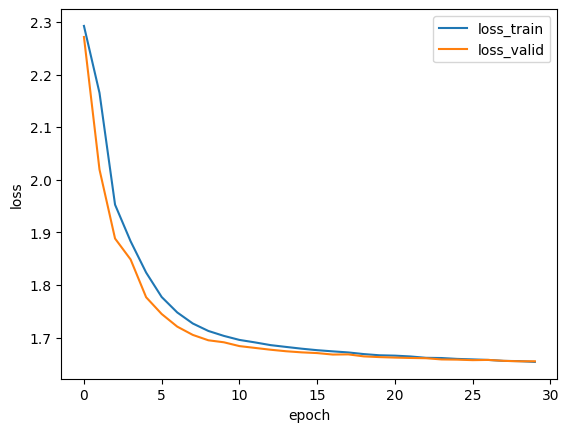

In [54]:
# instantiate model and move to device:
model = CustomNetwork().to(device)

# train model:
history = fit(model, loader_train, loader_valid, epochs=30, lr=.01)

# plot history:
history[['loss_train', 'loss_valid']].plot(xlabel='epoch', ylabel='loss')

**Evaluation**: `evaluate` will return the metric scores!

In [55]:
evaluate(model, loader_test) #evaluate on the test set

{'f1': 1.0}

---

<span style="color:red"><b>TASK 4</b> - Improved Training:</span>

---

Improve the above training loop with the following steps:
1. replace the very basic SGD optimizer with the momentum-based [`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer. Compare how the learning curves change after this step. **As ADAM is more sensitive to the learning rate, set it to `0.001` after changing the optimizer!**
2. add a [`torch.optim.lr_scheduler.LinearLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html) scheduler (_start: `1.0*lr`, end:`0.33*lr`, over 10 epochs_).  Compare how the learning curves change after this step.
3. add an **early stopping** functionality, that stops training when the validation loss has not improved for `patience` epochs and restores the model parameters to the ones achieving the best loss. **Use a patience of `5` to retrain the network.**

**Disclaimer:** *We will not check whether you actually compare the loss curves before and after adding a specific step. But we may ask about their impact in the final exam.*

In [56]:
def epoch(model:CustomNetwork, loader_train:DataLoader, optimizer:pt.optim.Optimizer, loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]):
  model.train()

  losses = None if loss_fn is None else []
  with pt.enable_grad():
    for X_batch, y_batch in loader_train:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      optimizer.zero_grad()
      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())
      loss.backward()
      optimizer.step()

  return np.mean(losses)

def evaluate(model:CustomNetwork, loader_valid:DataLoader, loss_fn:Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]]=None):
  model.eval()

  labels = []
  predictions = []
  losses = None if loss_fn is None else []
  for X_batch, y_batch in loader_valid:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    labels.extend(y_batch.cpu().detach().numpy())
    y_pred = model(X_batch)
    predictions.extend(y_pred.cpu().detach().numpy())
    if loss_fn is not None:
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())
  f1 = f1_score(
    y_batch.cpu().detach().numpy(),
    y_pred.argmax(dim=1).cpu().detach().numpy(),
    average='macro'
  )
  if loss_fn is None: return {'f1':f1}
  else: return {'loss':np.mean(losses), 'f1':f1}

def fit(model:CustomNetwork, loader_train:DataLoader, loader_valid:DataLoader, epochs:int, lr:float, patience:int):
  optimizer = pt.optim.Adam(model.parameters(), lr=lr)
  scheduler = pt.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=0.33,
        total_iters=10
    )
  loss_fn = pt.nn.CrossEntropyLoss()

  best_loss = float('inf')
  best_state_dict = None
  no_improvement_epochs = 0
  history = []
  for i in range(epochs):
        loss_train = epoch(model, loader_train, optimizer, loss_fn)
        metrics = evaluate(model, loader_valid, loss_fn)
        scheduler.step()
        current_val_loss = metrics['loss'] #validation loss
        if current_val_loss < best_loss:
            best_loss = current_val_loss
            best_state_dict = model.state_dict()
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        history.append({
            'loss_train': loss_train,
            'loss_valid': metrics['loss'],
            'f1_valid': metrics['f1']
        })

        if no_improvement_epochs >= patience:
          model.load_state_dict(best_state_dict)
          break

  return pd.DataFrame(history)


---

*End of Task 4. Copy your final code to **Homework 2 - Code** on **NextIlearn***

### Section 4: Other useful and frequently used functions

Save and load the model.

**Option 1:** `torch.save(...)` / `torch.load(...)`

In [57]:
pt.save(model, 'model.pt')

In [58]:
# this saves a zipfile!
!unzip model.pt

Archive:  model.pt
 extracting: model/data.pkl          
 extracting: model/byteorder         
 extracting: model/data/0            
 extracting: model/data/1            
 extracting: model/data/2            
 extracting: model/data/3            
 extracting: model/data/4            
 extracting: model/data/5            
 extracting: model/version           
 extracting: model/.data/serialization_id  


In [59]:
model = pt.load('model.pt', weights_only=False) # "weights_only = True" only loads PyTorch Tensors in the model file!
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
           Dropout-2                  [-1, 300]               0
            Linear-3                  [-1, 200]          60,200
           Dropout-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


**Option 2:** save/load state_dict

In [60]:
import pickle

In [61]:
with open('model_state_dict.pkl', 'wb') as f:
  pickle.dump(model.state_dict(), f)

In [62]:
with open('model_state_dict.pkl', 'rb') as f:
  state_dict = pickle.load(f)
model.load_state_dict(state_dict)
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
           Dropout-2                  [-1, 300]               0
            Linear-3                  [-1, 200]          60,200
           Dropout-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


---

<span style="color:red"><b>TASK 5</b> - Regression MLP</span>

---

We have created a classification model on Fashion MNIST with PyTorch. In addition, we can of course use similar PyTorch models to solve regression tasks. **How can we do that?** Which part should we change to make it work on regression tasks? That would be our last task in this lab. Based on your knowledge from the second lecture, you may be able to figure out which part you need to change.

Create a regression model by adapting the PyTorch model we used above and train it on the [california housing dataset](https://nextilearn.dsv.su.se/mod/resource/view.php?id=25386 ).
You may need to change **a loss function** and input / output layers as we no longer deal with images and classification. Feel free to use scikit-learn but we still recommend you to practice preprocessing with NumPy for your skills.

**Upload the resulting predictions to NextIlearn. Your model should achieve an MSE < XXX to pass.**


1. Get training and test data:

In [79]:
# 1.1 download https://www.google.com/url?q=https%3A%2F%2Fnextilearn.dsv.su.se%2Fmod%2Fresource%2Fview.php%3Fid%3D25386 to data.zip

# 1.2 unzip data.zip
import zipfile,os

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()


#!unzip data.zip

# 1.3 check files:
os.listdir('data/task5')

['description.md', 'labels_train.csv', 'data_train.csv', 'data_test.csv']

2. Create Data Pipeline:

In [85]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
# 2.1 load training data:
data_train = pd.read_csv('data/task5/data_train.csv', index_col=0)
labels_train = pd.read_csv('data/task5/labels_train.csv', index_col=0)

# 2.2 load test data (no labels):
data_test = pd.read_csv('data/task5/data_test.csv', index_col=0)

#...
#print(data_train.head())
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(data_train)
X_test_scaled = scaler.transform(data_test)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled, labels_train.values.ravel(), test_size=0.2, random_state=42)

train_dataset = TensorDataset(pt.tensor(X_train, dtype=pt.float32), pt.tensor(y_train, dtype=pt.float32))
valid_dataset = TensorDataset(pt.tensor(X_valid, dtype=pt.float32), pt.tensor(y_valid, dtype=pt.float32))
loader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
loader_valid = DataLoader(valid_dataset, batch_size=32, shuffle=False)

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  4.3036      36.0  5.065630   1.069085      1115.0  1.925734     34.15   
1  2.9085      21.0  3.962923   1.102508      1985.0  2.164667     36.60   
2  4.1378      24.0  4.582307   1.000000      2819.0  3.156775     33.83   
3  4.5625      34.0  5.764120   1.056478      1019.0  3.385382     37.36   
4  4.3462      36.0  5.919492   1.108051      1334.0  2.826271     34.22   

   Longitude  
0    -118.38  
1    -121.86  
2    -118.29  
3    -121.98  
4    -118.51  


3. Create Model:

In [81]:
#...
class RegressionNetwork(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, x):
        x = F.relu(self.layer1(x))  #
        x = F.relu(self.layer2(x))
        return self.output_layer(x)

4. Train model on `data_train` and `labels_train`:

In [82]:
#...
def epoch_func(model, loader_train, optimizer, loss_fn):
    model.train()
    losses = []  # Store batch losses
    for X_batch, y_batch in loader_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
        optimizer.zero_grad()  # Reset gradients
        y_pred = model(X_batch)  # Forward pass
        loss = loss_fn(y_pred, y_batch)  # Compute loss
        losses.append(loss.item())  # Store loss value
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
    return np.mean(losses)  # Return average training loss
def evaluate_func(model, loader_valid, loss_fn):
    model.eval()
    losses = []  # Store batch losses
    predictions = []  # Store predictions
    with pt.no_grad():
      for X_batch, y_batch in loader_valid:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
        y_pred = model(X_batch)  # Forward pass
        loss = loss_fn(y_pred, y_batch)  # Compute loss
        losses.append(loss.item())  # Store loss value
        predictions.extend(y_pred.cpu().numpy())  # Store predictions

    return {'loss': np.mean(losses), 'predictions': predictions}  # Return average validation loss and predictions

def fit_func(model, loader_train, loader_valid, epochs, lr, patience):
    optimizer = pt.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    scheduler = pt.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.33, total_iters=10)  # Learning rate scheduler
    loss_fn = pt.nn.MSELoss()

    best_loss = float('inf')
    best_state_dict = None
    no_improvement_epochs = 0
    history = []

    for epoch in range(epochs):
        train_loss = epoch_func(model, loader_train, optimizer, loss_fn)
        metrics = evaluate_func(model, loader_valid, loss_fn)
        scheduler.step()
        val_loss = metrics['loss'] #validationloss
        # Early stopping logic
        if val_loss < best_loss:
            best_loss = val_loss
            best_state_dict = model.state_dict()
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1


        history.append({'train_loss': train_loss, 'val_loss': val_loss})

        if no_improvement_epochs >= patience:
          model.load_state_dict(best_state_dict)
          break

    return pd.DataFrame(history)

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
model = RegressionNetwork(input_dim=X_train.shape[1]).to(device)
history = fit_func(model, loader_train, loader_valid, epochs=30, lr=0.001, patience=10)

5. Predict `data_test` and save predictions to `submission.csv`:

In [83]:
model.eval()
with pt.no_grad():
  X_test_tensor = pt.tensor(X_test_scaled, dtype=pt.float32).to(device)
  predictions = model(X_test_tensor)

pd.DataFrame(predictions.detach().cpu().numpy(), columns=['predictions']).to_csv('submission.csv')

---

*End of Task 5. Upload your final predictions (the file* `submission.csv` *) to **Homework 2 - Code** on **NextIlearn***